In [ ]:
abc = float(input("Welcome"))
print (type(abc))

In [1]:
from matplotlib.testing.conftest import (mpl_test_settings,
                                         mpl_image_comparison_parameters,
                                         pytest_configure, pytest_unconfigure,
                                         pd)


In [10]:
from io import BytesIO
import pytest
import logging

from matplotlib import afm
from matplotlib import font_manager as fm


# See note in afm.py re: use of comma as decimal separator in the
# UnderlineThickness field and re: use of non-ASCII characters in the Notice
# field.
AFM_TEST_DATA = b"""StartFontMetrics 2.0
Comment Comments are ignored.
Comment Creation Date:Mon Nov 13 12:34:11 GMT 2017
FontName MyFont-Bold
EncodingScheme FontSpecific
FullName My Font Bold
FamilyName Test Fonts
Weight Bold
ItalicAngle 0.0
IsFixedPitch false
UnderlinePosition -100
UnderlineThickness 56,789
Version 001.000
Notice Copyright \xa9 2017 No one.
FontBBox 0 -321 1234 369
StartCharMetrics 3
C 0 ; WX 250 ; N space ; B 0 0 0 0 ;
C 42 ; WX 1141 ; N foo ; B 40 60 800 360 ;
C 99 ; WX 583 ; N bar ; B 40 -10 543 210 ;
EndCharMetrics
EndFontMetrics
"""


def test_nonascii_str():
    # This tests that we also decode bytes as utf-8 properly.
    # Else, font files with non ascii characters fail to load.
    inp_str = "привет"
    byte_str = inp_str.encode("utf8")

    ret = afm._to_str(byte_str)
    assert ret == inp_str


def test_parse_header():
    fh = BytesIO(AFM_TEST_DATA)
    header = afm._parse_header(fh)
    assert header == {
        b'StartFontMetrics': 2.0,
        b'FontName': 'MyFont-Bold',
        b'EncodingScheme': 'FontSpecific',
        b'FullName': 'My Font Bold',
        b'FamilyName': 'Test Fonts',
        b'Weight': 'Bold',
        b'ItalicAngle': 0.0,
        b'IsFixedPitch': False,
        b'UnderlinePosition': -100,
        b'UnderlineThickness': 56.789,
        b'Version': '001.000',
        b'Notice': b'Copyright \xa9 2017 No one.',
        b'FontBBox': [0, -321, 1234, 369],
        b'StartCharMetrics': 3,
    }


def test_parse_char_metrics():
    fh = BytesIO(AFM_TEST_DATA)
    afm._parse_header(fh)  # position
    metrics = afm._parse_char_metrics(fh)
    assert metrics == (
        {0: (250.0, 'space', [0, 0, 0, 0]),
         42: (1141.0, 'foo', [40, 60, 800, 360]),
         99: (583.0, 'bar', [40, -10, 543, 210]),
         },
        {'space': (250.0, 'space', [0, 0, 0, 0]),
         'foo': (1141.0, 'foo', [40, 60, 800, 360]),
         'bar': (583.0, 'bar', [40, -10, 543, 210]),
         })


def test_get_familyname_guessed():
    fh = BytesIO(AFM_TEST_DATA)
    font = afm.AFM(fh)
    del font._header[b'FamilyName']  # remove FamilyName, so we have to guess
    assert font.get_familyname() == 'My Font'


def test_font_manager_weight_normalization():
    font = afm.AFM(BytesIO(
        AFM_TEST_DATA.replace(b"Weight Bold\n", b"Weight Custom\n")))
    assert fm.afmFontProperty("", font).weight == "normal"


@pytest.mark.parametrize(
    "afm_data",
    [
        b"""nope
really nope""",
        b"""StartFontMetrics 2.0
Comment Comments are ignored.
Comment Creation Date:Mon Nov 13 12:34:11 GMT 2017
FontName MyFont-Bold
EncodingScheme FontSpecific""",
    ],
)
def test_bad_afm(afm_data):
    fh = BytesIO(afm_data)
    with pytest.raises(RuntimeError):
        header = afm._parse_header(fh)


@pytest.mark.parametrize(
    "afm_data",
    [
        b"""StartFontMetrics 2.0
Comment Comments are ignored.
Comment Creation Date:Mon Nov 13 12:34:11 GMT 2017
Aardvark bob
FontName MyFont-Bold
EncodingScheme FontSpecific
StartCharMetrics 3""",
        b"""StartFontMetrics 2.0
Comment Comments are ignored.
Comment Creation Date:Mon Nov 13 12:34:11 GMT 2017
ItalicAngle zero degrees
FontName MyFont-Bold
EncodingScheme FontSpecific
StartCharMetrics 3""",
    ],
)
def test_malformed_header(afm_data, caplog):
    fh = BytesIO(afm_data)
    with caplog.at_level(logging.ERROR):
        header = afm._parse_header(fh)

    assert len(caplog.records) == 1

In [8]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.testing.decorators import image_comparison


@image_comparison(baseline_images=['agg_filter_alpha'],
                  extensions=['png', 'pdf'])
def test_agg_filter_alpha():
    ax = plt.axes()
    x, y = np.mgrid[0:7, 0:8]
    data = x**2 - y**2
    mesh = ax.pcolormesh(data, cmap='Reds', zorder=5)

    def manual_alpha(im, dpi):
        im[:, :, 3] *= 0.6
        print('CALLED')
        return im, 0, 0

    # Note: Doing alpha like this is not the same as setting alpha on
    # the mesh itself. Currently meshes are drawn as independent patches,
    # and we see fine borders around the blocks of color. See the SO
    # question for an example: https://stackoverflow.com/questions/20678817
    mesh.set_agg_filter(manual_alpha)

    # Currently we must enable rasterization for this to have an effect in
    # the PDF backend.
    mesh.set_rasterized(True)

    ax.plot([0, 4, 7], [1, 3, 8])


In [9]:
import io

import numpy as np
from numpy.testing import assert_array_almost_equal
from PIL import Image, TiffTags
import pytest


from matplotlib import (
    collections, path, pyplot as plt, transforms as mtransforms, rcParams)
from matplotlib.image import imread
from matplotlib.figure import Figure
from matplotlib.testing.decorators import image_comparison


def test_repeated_save_with_alpha():
    # We want an image which has a background color of bluish green, with an
    # alpha of 0.25.

    fig = Figure([1, 0.4])
    fig.set_facecolor((0, 1, 0.4))
    fig.patch.set_alpha(0.25)

    # The target color is fig.patch.get_facecolor()

    buf = io.BytesIO()

    fig.savefig(buf,
                facecolor=fig.get_facecolor(),
                edgecolor='none')

    # Save the figure again to check that the
    # colors don't bleed from the previous renderer.
    buf.seek(0)
    fig.savefig(buf,
                facecolor=fig.get_facecolor(),
                edgecolor='none')

    # Check the first pixel has the desired color & alpha
    # (approx: 0, 1.0, 0.4, 0.25)
    buf.seek(0)
    assert_array_almost_equal(tuple(imread(buf)[0, 0]),
                              (0.0, 1.0, 0.4, 0.250),
                              decimal=3)


def test_large_single_path_collection():
    buff = io.BytesIO()

    # Generates a too-large single path in a path collection that
    # would cause a segfault if the draw_markers optimization is
    # applied.
    f, ax = plt.subplots()
    collection = collections.PathCollection(
        [path.Path([[-10, 5], [10, 5], [10, -5], [-10, -5], [-10, 5]])])
    ax.add_artist(collection)
    ax.set_xlim(10**-3, 1)
    plt.savefig(buff)


def test_marker_with_nan():
    # This creates a marker with nans in it, which was segfaulting the
    # Agg backend (see #3722)
    fig, ax = plt.subplots(1)
    steps = 1000
    data = np.arange(steps)
    ax.semilogx(data)
    ax.fill_between(data, data*0.8, data*1.2)
    buf = io.BytesIO()
    fig.savefig(buf, format='png')


def test_long_path():
    buff = io.BytesIO()

    fig, ax = plt.subplots()
    np.random.seed(0)
    points = np.random.rand(70000)
    ax.plot(points)
    fig.savefig(buff, format='png')


@image_comparison(['agg_filter.png'], remove_text=True)
def test_agg_filter():
    def smooth1d(x, window_len):
        # copied from http://www.scipy.org/Cookbook/SignalSmooth
        s = np.r_[
            2*x[0] - x[window_len:1:-1], x, 2*x[-1] - x[-1:-window_len:-1]]
        w = np.hanning(window_len)
        y = np.convolve(w/w.sum(), s, mode='same')
        return y[window_len-1:-window_len+1]

    def smooth2d(A, sigma=3):
        window_len = max(int(sigma), 3) * 2 + 1
        A = np.apply_along_axis(smooth1d, 0, A, window_len)
        A = np.apply_along_axis(smooth1d, 1, A, window_len)
        return A

    class BaseFilter:

        def get_pad(self, dpi):
            return 0

        def process_image(self, padded_src, dpi):
            raise NotImplementedError("Should be overridden by subclasses")

        def __call__(self, im, dpi):
            pad = self.get_pad(dpi)
            padded_src = np.pad(im, [(pad, pad), (pad, pad), (0, 0)],
                                "constant")
            tgt_image = self.process_image(padded_src, dpi)
            return tgt_image, -pad, -pad

    class OffsetFilter(BaseFilter):

        def __init__(self, offsets=(0, 0)):
            self.offsets = offsets

        def get_pad(self, dpi):
            return int(max(self.offsets) / 72 * dpi)

        def process_image(self, padded_src, dpi):
            ox, oy = self.offsets
            a1 = np.roll(padded_src, int(ox / 72 * dpi), axis=1)
            a2 = np.roll(a1, -int(oy / 72 * dpi), axis=0)
            return a2

    class GaussianFilter(BaseFilter):
        """Simple Gaussian filter."""

        def __init__(self, sigma, alpha=0.5, color=(0, 0, 0)):
            self.sigma = sigma
            self.alpha = alpha
            self.color = color

        def get_pad(self, dpi):
            return int(self.sigma*3 / 72 * dpi)

        def process_image(self, padded_src, dpi):
            tgt_image = np.empty_like(padded_src)
            tgt_image[:, :, :3] = self.color
            tgt_image[:, :, 3] = smooth2d(padded_src[:, :, 3] * self.alpha,
                                          self.sigma / 72 * dpi)
            return tgt_image

    class DropShadowFilter(BaseFilter):

        def __init__(self, sigma, alpha=0.3, color=(0, 0, 0), offsets=(0, 0)):
            self.gauss_filter = GaussianFilter(sigma, alpha, color)
            self.offset_filter = OffsetFilter(offsets)

        def get_pad(self, dpi):
            return max(self.gauss_filter.get_pad(dpi),
                       self.offset_filter.get_pad(dpi))

        def process_image(self, padded_src, dpi):
            t1 = self.gauss_filter.process_image(padded_src, dpi)
            t2 = self.offset_filter.process_image(t1, dpi)
            return t2

    fig, ax = plt.subplots()

    # draw lines
    l1, = ax.plot([0.1, 0.5, 0.9], [0.1, 0.9, 0.5], "bo-",
                  mec="b", mfc="w", lw=5, mew=3, ms=10, label="Line 1")
    l2, = ax.plot([0.1, 0.5, 0.9], [0.5, 0.2, 0.7], "ro-",
                  mec="r", mfc="w", lw=5, mew=3, ms=10, label="Line 1")

    gauss = DropShadowFilter(4)

    for l in [l1, l2]:

        # draw shadows with same lines with slight offset.
        xx = l.get_xdata()
        yy = l.get_ydata()
        shadow, = ax.plot(xx, yy)
        shadow.update_from(l)

        # offset transform
        ot = mtransforms.offset_copy(l.get_transform(), ax.figure,
                                     x=4.0, y=-6.0, units='points')

        shadow.set_transform(ot)

        # adjust zorder of the shadow lines so that it is drawn below the
        # original lines
        shadow.set_zorder(l.get_zorder() - 0.5)
        shadow.set_agg_filter(gauss)
        shadow.set_rasterized(True)  # to support mixed-mode renderers

    ax.set_xlim(0., 1.)
    ax.set_ylim(0., 1.)

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)


def test_too_large_image():
    fig = plt.figure(figsize=(300, 1000))
    buff = io.BytesIO()
    with pytest.raises(ValueError):
        fig.savefig(buff)


def test_chunksize():
    x = range(200)

    # Test without chunksize
    fig, ax = plt.subplots()
    ax.plot(x, np.sin(x))
    fig.canvas.draw()

    # Test with chunksize
    fig, ax = plt.subplots()
    rcParams['agg.path.chunksize'] = 105
    ax.plot(x, np.sin(x))
    fig.canvas.draw()


@pytest.mark.backend('Agg')
def test_jpeg_dpi():
    # Check that dpi is set correctly in jpg files.
    plt.plot([0, 1, 2], [0, 1, 0])
    buf = io.BytesIO()
    plt.savefig(buf, format="jpg", dpi=200)
    im = Image.open(buf)
    assert im.info['dpi'] == (200, 200)


def test_pil_kwargs_png():
    from PIL.PngImagePlugin import PngInfo
    buf = io.BytesIO()
    pnginfo = PngInfo()
    pnginfo.add_text("Software", "test")
    plt.figure().savefig(buf, format="png", pil_kwargs={"pnginfo": pnginfo})
    im = Image.open(buf)
    assert im.info["Software"] == "test"


def test_pil_kwargs_tiff():
    buf = io.BytesIO()
    pil_kwargs = {"description": "test image"}
    plt.figure().savefig(buf, format="tiff", pil_kwargs=pil_kwargs)
    im = Image.open(buf)
    tags = {TiffTags.TAGS_V2[k].name: v for k, v in im.tag_v2.items()}
    assert tags["ImageDescription"] == "test image"


In [11]:
test_nonascii_str()

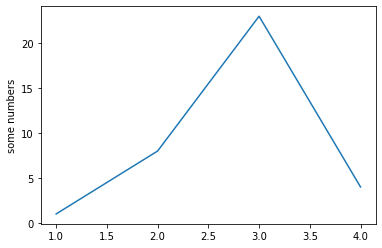

In [14]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3, 4],[1,8,23,4])
plt.ylabel('some numbers')
plt.show()